# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

### <span style="color:brown">Data Pre-Processing</span>

In this block of code, we have imported the data.

In [1]:
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
data = pd.read_csv('../data_modules/SBIN.csv', index_col=0,
                   parse_dates=True, na_values=0).dropna()

### <span style="color:brown"> Creating the input and target features

Now, we will create a feature data set called  <font color =red>X</font> which will be used to create the input for the LSTM model.<br> 

Next, we create a dataset called <font color =red>y</font> which will contain the future close values.<br>

The model will train to predict these values of future close prices.

In [3]:
X = data[['Open', 'High', 'Low', 'Close', 'Volume']]
y = data.Last.shift(-1)

Dividing the data into train and test sets before scaling 

In [4]:
test_size = int(0.3*(len(X)))
X_train = X[:-test_size]
X_test = X[-test_size:]

y_train = y[:-test_size]
y_test = y[-test_size:]

Scaling train and test sets separately

In [5]:
scl = StandardScaler()

X_train_scaled=scl.fit_transform(X_train)
X_train= X_train.assign(Open=X_train_scaled[:, 0])
X_train= X_train.assign(High=X_train_scaled[:, 1])
X_train= X_train.assign(Low=X_train_scaled[:, 2])
X_train= X_train.assign(Close=X_train_scaled[:, 3])
X_train= X_train.assign(Volume=X_train_scaled[:, 4])


X_test_scaled=scl.transform(X_test)

X_test= X_test.assign(Open=X_test_scaled[:, 0])
X_test= X_test.assign(High=X_test_scaled[:, 1])
X_test= X_test.assign(Low=X_test_scaled[:, 2])
X_test= X_test.assign(Close=X_test_scaled[:, 3])
X_test= X_test.assign(Volume=X_test_scaled[:, 4])

Using timesteps of 20 days to create the input data

In [6]:
timestep = 20
X_train_list = []
y_train_list = []
for i in range(timestep, len(X_train)):
    X_train_list.append(np.array(X_train.iloc[i-timestep:i]))
    y_train_list.append(y_train.iloc[i:i+timestep].values)
    
X_test_list = []
y_test_list = []
for i in range(timestep, len(X_test)):
    X_test_list.append(np.array(X_test.iloc[i-timestep:i]))
    y_test_list.append(y_test.iloc[i:i+timestep].values)    

In [7]:
X_train = np.array(X_train_list)
X_test = np.array(X_test_list)    

### <span style="color:brown">Creating an LSTM model

First, we import the necessary modules for the model from the keras library.

In this model, I have added a dropout layer with an 80% drop ratio. If you choose a model that is is not very deep then the chances of over-fitting are very less and you may not need a dropout layer. 

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
# Please note that the number of neurons used in LSTM model is lesser than those in the RNN model
neurons = 200
act = 'tanh'
dropout_ratio = 0.80

Let us begin to build the model, as you might recall the first layer will always be a sequential one. Followed by an LSTM in this case, as we want to test a simple LSTM model to check the accuracy.

After this, I have added a few Dense layers (fully connected Neural Network) along with the dropout layers.

As the depth of the model increases, the model's ability to create complex features also increases. But, this often results in overfitting.

In [9]:
model = Sequential()
model.add(LSTM(4, input_shape=(
    X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dense(neurons, activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons*2, activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons*3, activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons*4, activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons*5, activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

### <span style="color:brown"> Saving and loading the model

In Keras, we can save the best weights of the model by creating a checkpoint during the training of the model. To create a checkpoint, we specify the metric that needs to be monitored and saved accordingly. In this example, I have passed the validation set loss as the monitoring parameter and specified the mode of saving as 'auto'. This means that the model will save the weights of the network whenever a now low value for the validation loss is generated. 

I have specified the file path as LSTM-weights-best.hdf5 to save the weights of the model.

The verbose=1 parameter defines how much information about every batch training needs to be printed

#### We strongly encourage you to change all the parameters discussed above to create your own models and test them out.

Also, please be reasonable in specifying the depth and number of neurons in a model, else you may not get a result in a reasonable time.

In [10]:
filepath = "LSTM-weights-best.hdf5"
checkpoint = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

Now let us visualize our model.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 4)             160       
                                                                 
 dense (Dense)               (None, 20, 200)           1000      
                                                                 
 dropout (Dropout)           (None, 20, 200)           0         
                                                                 
 dense_1 (Dense)             (None, 20, 400)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 20, 400)           0         
                                                                 
 dense_2 (Dense)             (None, 20, 600)           240600    
                                                                 
 dropout_2 (Dropout)         (None, 20, 600)           0

Now, it's time to train the model.

While training the model we have to specify the size of the batch, this indicates to the model how many train samples it should take in a single batch while training.

The validation split randomly splits the train data to verify the performance of the model on untrained data.

Epochs are the number of runs the model needs to make for the convergence of train and validation losses.

In [12]:
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1,
          validation_split=0.2, callbacks=[checkpoint])

Epoch 1/100
536/536 [==============================] - ETA: 0s - loss: 10519.7393 - mse: 10519.7393
Epoch 00001: val_loss improved from inf to 2175.43311, saving model to LSTM-weights-best.hdf5
536/536 [==============================] - 23s 37ms/step - loss: 10519.7393 - mse: 10519.7393 - val_loss: 2175.4331 - val_mse: 2175.4331
Epoch 2/100
536/536 [==============================] - ETA: 0s - loss: 1653.9462 - mse: 1653.9462- ETA: 2s - 
Epoch 00002: val_loss improved from 2175.43311 to 1992.42273, saving model to LSTM-weights-best.hdf5
536/536 [==============================] - 15s 29ms/step - loss: 1653.9462 - mse: 1653.9462 - val_loss: 1992.4227 - val_mse: 1992.4227
Epoch 3/100
535/536 [============================>.] - ETA: 0s - loss: 1678.4099 - mse: 1678.4099
Epoch 00003: val_loss did not improve from 1992.42273
536/536 [==============================] - 12s 23ms/step - loss: 1676.3553 - mse: 1676.3553 - val_loss: 2261.0317 - val_mse: 2261.0317
Epoch 4/100
534/536 [===============

Epoch 29/100
535/536 [============================>.] - ETA: 0s - loss: 547.6520 - mse: 547.6520
Epoch 00029: val_loss did not improve from 129.66423
536/536 [==============================] - 17s 31ms/step - loss: 548.3751 - mse: 548.3751 - val_loss: 137.0968 - val_mse: 137.0968
Epoch 30/100
534/536 [============================>.] - ETA: 0s - loss: 514.7123 - mse: 514.7123
Epoch 00030: val_loss did not improve from 129.66423
536/536 [==============================] - 12s 21ms/step - loss: 513.8611 - mse: 513.8611 - val_loss: 245.2607 - val_mse: 245.2607
Epoch 31/100
534/536 [============================>.] - ETA: 0s - loss: 506.2781 - mse: 506.2781
Epoch 00031: val_loss did not improve from 129.66423
536/536 [==============================] - 16s 29ms/step - loss: 506.0310 - mse: 506.0310 - val_loss: 155.1777 - val_mse: 155.1777
Epoch 32/100
536/536 [==============================] - ETA: 0s - loss: 546.0923 - mse: 546.0923
Epoch 00032: val_loss improved from 129.66423 to 118.59933, 

535/536 [============================>.] - ETA: 0s - loss: 479.6889 - mse: 479.6889
Epoch 00057: val_loss did not improve from 81.43081
536/536 [==============================] - 14s 26ms/step - loss: 479.2996 - mse: 479.2996 - val_loss: 90.8866 - val_mse: 90.8866
Epoch 58/100
536/536 [==============================] - ETA: 0s - loss: 509.6698 - mse: 509.6698
Epoch 00058: val_loss did not improve from 81.43081
536/536 [==============================] - 15s 28ms/step - loss: 509.6698 - mse: 509.6698 - val_loss: 86.0659 - val_mse: 86.0659
Epoch 59/100
535/536 [============================>.] - ETA: 0s - loss: 489.8072 - mse: 489.8072
Epoch 00059: val_loss did not improve from 81.43081
536/536 [==============================] - 13s 25ms/step - loss: 489.9672 - mse: 489.9672 - val_loss: 121.3452 - val_mse: 121.3452
Epoch 60/100
534/536 [============================>.] - ETA: 0s - loss: 519.6192 - mse: 519.6192
Epoch 00060: val_loss did not improve from 81.43081
536/536 [===================

535/536 [============================>.] - ETA: 0s - loss: 501.4082 - mse: 501.4082
Epoch 00086: val_loss did not improve from 65.19260
536/536 [==============================] - 14s 25ms/step - loss: 502.0113 - mse: 502.0113 - val_loss: 88.4627 - val_mse: 88.4627
Epoch 87/100
534/536 [============================>.] - ETA: 0s - loss: 478.2889 - mse: 478.2889
Epoch 00087: val_loss did not improve from 65.19260
536/536 [==============================] - 15s 27ms/step - loss: 477.3643 - mse: 477.3643 - val_loss: 208.8250 - val_mse: 208.8250
Epoch 88/100
534/536 [============================>.] - ETA: 0s - loss: 477.1680 - mse: 477.1680
Epoch 00088: val_loss did not improve from 65.19260
536/536 [==============================] - 12s 23ms/step - loss: 477.5948 - mse: 477.5948 - val_loss: 155.5184 - val_mse: 155.5184
Epoch 89/100
535/536 [============================>.] - ETA: 0s - loss: 493.0699 - mse: 493.0699
Epoch 00089: val_loss did not improve from 65.19260
536/536 [=================

Once we have generated the best weights and saved them using the callback feature, we would want our final model to have these best weights fitted before making the predictions on the test data. So, we load these weights using the load_weights function.

In [13]:
model.load_weights(filepath)

### <span style="color:brown"> Predicting the Close Prices

Now, we will create a list that would hold the LSTM model's predictions on the test data.

After this, we create a dataframe called `performance` that contains the actual close values and the predicted close values to analyze the predictions.

In [14]:
predict_close = []
predict_close = list(model.predict(X_test))

In [15]:
predicted_close = []
for i in range(len(predict_close)):
    predicted_close.append((predict_close[i][0][0]))
predicted_close

[240.48997,
 246.03822,
 255.06955,
 226.22263,
 270.66486,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 290.04462,
 272.9369,
 269.27264,
 272.7671,
 269.00647,
 260.0

In [16]:
actual_close = []
for i in range(timestep,len(y_test)):
    actual_close.append((y_test[i]))
actual_close

[333.0,
 330.65,
 335.3,
 334.95,
 332.4,
 335.65,
 332.0,
 328.9,
 320.35,
 312.75,
 313.6,
 319.1,
 312.4,
 316.4,
 313.1,
 318.4,
 318.45,
 313.3,
 314.0,
 312.25,
 318.9,
 319.8,
 317.5,
 316.75,
 319.85,
 317.15,
 314.85,
 308.4,
 309.9,
 307.1,
 303.25,
 302.85,
 308.5,
 306.35,
 305.8,
 304.3,
 301.1,
 302.2,
 302.25,
 302.6,
 296.15,
 307.1,
 303.25,
 309.25,
 306.5,
 318.1,
 329.9,
 313.15,
 312.1,
 313.55,
 313.25,
 306.05,
 297.35,
 298.05,
 291.75,
 292.8,
 301.4,
 296.4,
 288.75,
 276.2,
 278.7,
 271.65,
 268.5,
 269.65,
 273.3,
 272.6,
 276.05,
 274.45,
 267.6,
 268.0,
 262.15,
 263.5,
 256.55,
 246.65,
 256.8,
 253.25,
 252.85,
 254.7,
 257.05,
 253.7,
 252.3,
 247.95,
 249.1,
 248.0,
 241.55,
 234.8,
 246.5,
 254.35,
 249.9,
 246.15,
 250.5,
 247.3,
 259.3,
 259.7,
 260.649,
 263.3,
 257.05,
 253.8,
 250.95,
 249.0,
 248.15,
 246.45,
 246.15,
 241.2,
 242.45,
 240.6,
 237.2,
 233.2,
 242.6,
 246.4,
 241.0,
 241.9,
 241.95,
 246.5,
 250.05,
 248.0,
 247.95,
 250.35,
 253

In [17]:
performance = pd.DataFrame([list(predicted_close), list(actual_close)])

In [18]:
performance = performance.T

In [19]:
performance.columns = ['Predicted', 'Actual']
Spread = performance.Actual-performance.Predicted

In [20]:
performance.tail()

,Predicted,Actual
270,279.294128,293.05
271,279.459900,294.15
272,290.042053,292.15
273,288.279724,294.80
274,278.818359,NaN


Now we will plot and see how the spread between the Actual and Predicted prices behaves. If the spread is mean reverting, then we can use this knowledge to create good entry and exit points for already exiting trades, or we enter new positions. 

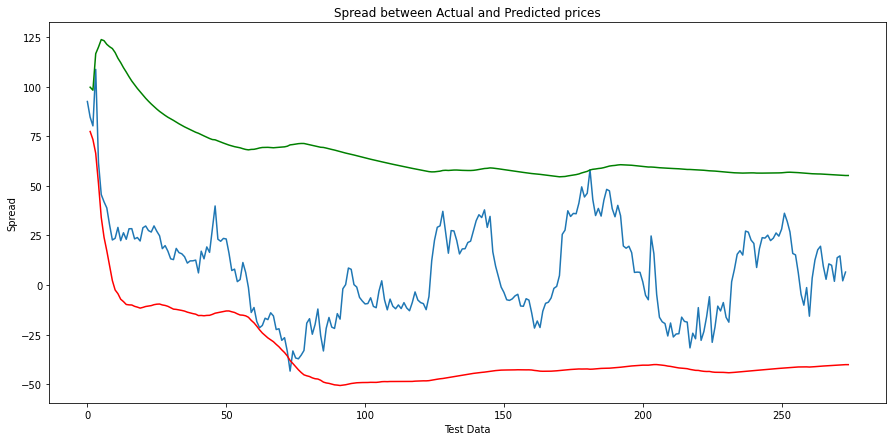

In [21]:
# Here s stands for the standard deviation range for the spread, beyond which we will consider the entry and exit positions
# Feel free to change this s value to generate different signals
s = 2
plt.figure(figsize=(15, 7))
plt.title('Spread between Actual and Predicted prices')
plt.plot(Spread)
#Plotting the upper and lower bollinger bands
plt.plot(Spread.expanding().mean()+s*Spread.expanding().std(), c='g')
plt.plot(Spread.expanding().mean()-s*Spread.expanding().std(), c='r')
plt.ylabel('Spread')
plt.xlabel('Test Data')
plt.show()

### <span style="color:brown"> Visualizing and comparing the performance

Now, let us plot the predicted and actual values of the close prices.

In this strategy, we have generated a buy signal every time the spread value has gone below the lower standard deviation line.
Conversely, we have generated a sell signal every time the spread value has gone above the upper standard deviation line.

####  Please note: The strategy given here is a mean-reverting model that could be used for paper trading. Please do not use this in real trading without extensive backtesting.

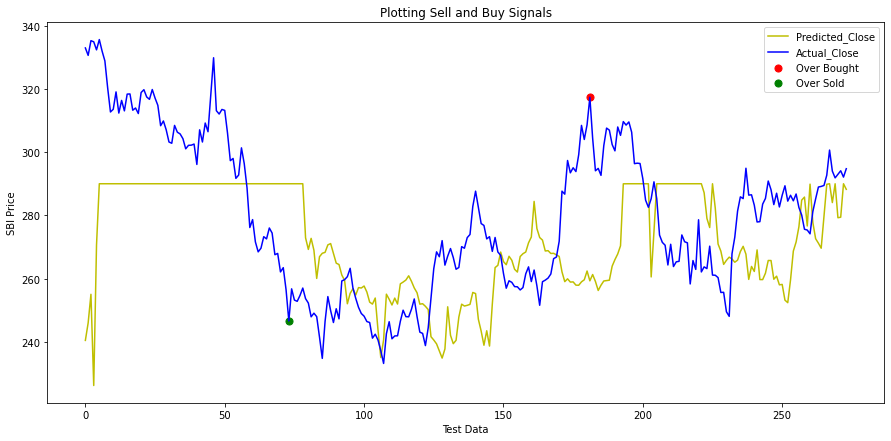

In [22]:
plt.figure(figsize=(15, 7))
plt.title('Plotting Sell and Buy Signals')
# Plot the predicted and actual prices for comparison
plt.plot(performance.Predicted.iloc[:-1], c='y')
plt.plot(performance.Actual, c='b')

# Plot the sell signlas wherever the Spread is above the upper standard deviation band
plt.scatter(performance.Actual[(Spread > Spread.expanding().mean()+s*Spread.expanding().std())].index,
            performance.Actual[(Spread > Spread.expanding().mean()+s*Spread.expanding().std())], c='r', s=50)

# Plot the buy signlas wherever the Spread is below the lower standard deviation band
plt.scatter(performance.Actual[(Spread < Spread.expanding().mean()-s*Spread.expanding().std())].index,
            performance.Actual[(Spread < Spread.expanding().mean()-s*Spread.expanding().std())], c='g', s=50)

plt.legend(['Predicted_Close', 'Actual_Close', 'Over Bought', 'Over Sold'])
plt.ylabel('SBI Price')
plt.xlabel('Test Data')
plt.show()

### Conclusion

As you can see in the plot above, in the initial days, the LSTM didnt perform well but as the days progressed, the model predicted the price which can be used to generate buy and sell signals as per the spread between actual and the predicted prices. The model performance can be improved using more features and extending the training dataset. 